# Deep Learning - 1

## Chapter 5. CNN and GAN

### Max pooling code implementation from scratch

---------------

### Import

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

### Model

#### Linear Layer

In [117]:
class Layer_Linear:
    """Representing a neural network layer"""
    
    def __init__(self, n_inputs, n_outputs):
        """Initlize weights and bias"""
        self.weights = 0.01 * np.random.randn(n_inputs, n_outputs)
        self.biases = np.zeros((1, n_outputs))
    
    def forward(self, inputs):
        """
        It multiplies the inputs by the weights 
        and then sums them, and then sums bias.
        """
        #To calculate gradient, remembering input values
        self.inputs = inputs
        #Calculate outputs' values
        self.output = np.dot(inputs, self.weights) + self.biases
    
    def backward(self, dvalues):
        """Gradient with respect to parameters and input"""
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dresults = np.dot(dvalues, self.weights.T)

#### Dropout Layer

In [118]:
class Layer_Dropout:
    """Representing a dropout layer"""
    
    def __init__(self, rate):
        """Initlize the success rate of binomial distribution"""
        self.rate = 1 - rate
    
    def forward(self, inputs):
        """
        Generate the scaled mask and then
        apply the mask to the inputs values
        """
        #Generate the scaled mask
        self.scaled_mask = np.random.binomial(1, self.rate,
                                             size=inputs.shape) / self.rate
        #Calculate outputs' values
        self.output = inputs * self.scaled_mask
        
    def backward(self, dvalues):
        """
        Gradient with respect to inputs, and then
        multiply the dvalues accroding to the chain rule
        """
        self.dresults = self.scaled_mask * dvalues    

#### Convolutional layer

In [119]:
class Layer_Convolutional:
    """Representing a convolutional layer"""
    
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        """Initlize the filters and biases"""
        # KxFxFxC
        self.weights = 0.01 * np.random.randn(out_channels,
                                              in_channels,
                                              kernel_size, 
                                              kernel_size)
        self.biases = np.zeros((out_channels, 1))
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
            
    def forward(self, inputs):
        """Forward pass"""
        #To calculate gradient, remembering input values
        self.inputs = inputs
        #Batch, channel, height, width
        self.in_b, self.in_c, self.in_h, self.in_w = inputs.shape
        #Calculate output dimensions
        out_dim_h = int((self.in_h - self.kernel_size) / self.stride ) + 1
        out_dim_w = int((self.in_w - self.kernel_size) / self.stride ) + 1
        #Initialize the output shape
        self.output = np.zeros((self.in_b, self.out_channels, out_dim_h, out_dim_w))
        #Calculate output's values
        for n in range(self.in_b):
            for current_filter in range(self.out_channels):
                current_y = out_y = 0
                while current_y + self.kernel_size <= self.in_h:
                    current_x = out_x = 0
                    while current_x + self.kernel_size <= self.in_w:
                        dot_prod = np.sum(self.weights[current_filter] * \
                                                        inputs[n, :, current_y:current_y+self.kernel_size,
                                                              current_x:current_x+self.kernel_size])
                        self.output[n, current_filter, out_y, out_x] = dot_prod + self.biases[current_filter]
                        current_x += self.stride
                        out_x += 1
                    current_y += self.stride
                    out_y += 1
                    
    def backward(self, dvalues):
        """Backward pass"""
        #Initialize the shapes
        self.dresults = np.zeros(self.inputs.shape)
        self.dweights = np.zeros(self.weights.shape)
        self.dbiases = np.zeros(self.biases.shape)
        #Calculate gradients with respect to weights, biases, and inputs
        for n in range(self.in_b):
            for current_filter in range(self.out_channels):
                current_y = out_y = 0
                while current_y + self.kernel_size <= self.in_h:
                    current_x = out_x = 0
                    while current_x + self.kernel_size <= self.in_w:
                        self.dweights[current_filter] += dvalues[n, current_filter, out_y, out_x] * \
                                                            self.inputs[n, :, current_y:current_y+self.kernel_size,
                                                                       current_x:current_x+self.kernel_size]

                        self.dresults[n, :, current_y:current_y+self.kernel_size,
                                     current_x:current_x+self.kernel_size] += dvalues[n, current_filter, out_y, out_x] * \
                                                                               self.weights[current_filter]
                        current_x += self.stride
                        out_x += 1
                    current_y += self.stride
                    out_y += 1
                self.dbiases[current_filter] = np.sum(dvalues[n, current_filter])

### Activation functions

#### Softmax Activation function

In [120]:
class Activation_Softmax:
    """Softmax activation"""
    
    def forward(self, inputs):
        """Forward pass"""
        
        #Compute e^x for each element of inputs
        #Due to the overflow error, 
        #Maximum value of per sample subtract from each row
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                           keepdims=True))
        
        #Normalize them for each batch
        self.output = exp_values / np.sum(exp_values, 
                                          axis=1, keepdims=True)
    
    def backward(self, dvalues):
        """Gradient softmax"""
        
        #Initialize an array
        self.dresults = np.zeros(dvalues.shape)
        
        for i in range(len(dvalues)):
            #Reshape the single output
            single_output = self.output[i].reshape(-1, 1)
            
            #Calculate Jacobian matrix of the single output
            jacobian_matrix = np.diagflat(single_output) - \
                                np.dot(single_output, single_output.T)
            
            #Multiply the Jacobian matrix by the loss function derivative
            self.dresults[i] = np.dot(jacobian_matrix, dvalues[i])

#### ReLU Activation function

In [121]:
class Activation_ReLU:
    """ReLU activation"""
    
    def forward(self, inputs):
        """Forward pass"""
        
        #To calculate gradient, remembering input values
        self.inputs = inputs
        
        #Calculate outputs' values
        self.output = np.maximum(0, inputs)
        
    def backward(self, dvalues):
        """Backward pass"""
        
        self.dresults = self.inputs > 0
        self.dresults = self.dresults * dvalues

### Pooling

#### Max pooling

In [17]:
class Pooling_Max:
    """Representing a maxpool layer"""
    
    def __init__(self, kernel_size, stride):
        """Initlize the kernel size and stride values"""
        self.kernel_size = kernel_size
        self.stride = stride
            
        
    def forward(self, inputs):
        """Forward pass"""
        #To calculate gradient, remembering input values
        self.inputs = inputs
        #Batch, channel, height, width
        self.in_b, self.in_c, self.in_h, self.in_w = inputs.shape
        #Calculate output dimensions
        out_dim_h = int((self.in_h - self.kernel_size) / self.stride ) + 1
        out_dim_w = int((self.in_w - self.kernel_size) / self.stride ) + 1
        #Initialize the output's shape
        self.output = np.zeros((self.in_b, self.in_c, out_dim_h, out_dim_w))
        #Calculate the output's values
        for n in range(self.in_b):
            for i in range(self.in_c):
                current_y = out_y = 0
                while current_y + self.kernel_size <= self.in_h:
                    current_x = out_x = 0
                    while current_x + self.kernel_size <= self.in_w:
                        self.output[n, i, out_y, out_x] = np.max(inputs[n, i, current_y:current_y+self.kernel_size,
                                                                       current_x:current_x+self.kernel_size])

                        current_x += self.stride
                        out_x += 1
                    current_y += self.stride
                    out_y += 1
    
    def nanargmax(self, arr):
        """
        Finding indexes of the maximal elements in a given array
        """
        idx = np.argmax(arr)
        idxs = np.unravel_index(idx, arr.shape)
        return idxs 
    
    def backward(self, dvalues):
        """Backward pass"""
        #Initialize the shapes
        self.dresults = np.zeros(self.inputs.shape)
        #Calculate gradients with respect to inputs
        for n in range(self.in_b):
            for i in range(self.in_c):
                current_y = out_y = 0
                while current_y + self.kernel_size <= self.in_h:
                    current_x = out_x = 0
                    while current_x + self.kernel_size <= self.in_w:
                        (a, b) = self.nanargmax(self.inputs[n, i, current_y:current_y+self.kernel_size,
                                                            current_x:current_x+self.kernel_size])

                        self.dresults[n, i, current_y+a, current_y+b] = dvalues[n, i, out_y, out_x]

                        current_x += self.stride
                        out_x += 1
                    current_y += self.stride
                    out_y += 1 

In [15]:
arr = np.array([[1, 9, 3],
                [4, 7, 61]])

In [16]:
idx = np.argmax(arr)
idxs = np.unravel_index(idx, arr.shape)
idxs

(1, 2)

### Loss

#### MSE

In [124]:
class Loss_MSE():
    """MSE Loss function"""
    
    def forward(self, y_pred, y_true):
        """Forward pass"""     
        error = np.mean((y_pred - y_true) ** 2)
        return error
    
    def backward(self, y_pred, y_true):
        """Derivative of MSE with respect to preds"""
        
        #Number of samples
        samples = len(y_pred)
        
        #Number of output nodes
        outputs = len(y_pred[0])
        
        #Derivative of MSE
        self.dresults = 2 * (y_pred - y_true) / (outputs * samples)

#### Categorical Cross-entropy

In [125]:
class Loss_CategoricalCrossEntropy():
    """Cross entropy Loss function"""
    
    def forward(self, y_pred, y_true):
        """Forward pass"""
        y_pred += 1e-10
        y_pred = np.clip(y_pred, None, 1)
        true_prediction = np.sum(y_pred * y_true, axis=1)
        error = np.mean(-np.log(true_prediction)) 
        return error
    
    def backward(self, y_pred, y_true):
        """Derivative of CCE with respect to preds"""
        
        #Number of samples
        samples = len(y_pred)
        
        self.dresults = -y_true / (y_pred * samples)

#### Categorical Cross-entropy + Softmax 

In [126]:
class Loss_CategoricalCrossEntropy_Activation_SoftMax:
    """Cateogircal cross entropy loss and SoftMax function"""
    
    def __init__(self):
        """Initialize Softmax and CCE loss"""
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossEntropy()
        
    def forward(self, inputs, y_true):
        """Forward pass"""
        self.activation.forward(inputs)
        return self.loss.forward(self.activation.output, y_true)
    
    def backward(self, y_pred, y_true):
        """Gradient of Categorical cross entropy + Softmax activation"""
        samples = len(y_pred)
        
        self.dresults = (y_pred - y_true) / samples        

### Accuracy

In [127]:
class Accuracy_Categorical:
    """Accuracy calculation for classification"""
    
    def calculate(self, y_pred, y_true):
        """Calculate the accuracy"""
        
        true = np.argmax(y_true, axis=1)
        pred = np.argmax(y_pred, axis=1)
        comparisons = true == pred
        
        accuracy = np.mean(comparisons)
        
        return accuracy

### Optimizer

#### Gradient descent 

In [128]:
class Optimizer_GD:
    """Gradient descent optimizer"""
    
    def __init__(self, alpha=1., momentum=0):
        """Initialize hyperparameters"""
        self.alpha = alpha
        self.momentum = momentum

    def update_parameters(self, layer):
        """Update parameters"""

        if self.momentum:
            
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            weights_delta = self.momentum * layer.weight_momentums + \
                            layer.dweights * self.alpha
            biases_delta = self.momentum * layer.bias_momentums + \
                            layer.dbiases * self.alpha
            
            layer.weight_momentums = weights_delta
            layer.bias_momentums = biases_delta
        
        else:
            
            weights_delta = layer.dweights * self.alpha
            biases_delta = layer.dbiases * self.alpha
        
        #Update parameters
        layer.weights -= weights_delta
        layer.biases -= biases_delta

#### AdaGrad

In [129]:
class Optimizer_AdaGrad:
    """Gradient descent optimizer"""
    
    def __init__(self, alpha=1., epsilon=1e-10):
        """Initialize hyperparameters"""
        self.alpha = alpha
        self.epsilon = epsilon

    def update_parameters(self, layer):
        """Update parameters"""
            
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_cache += layer.dweights ** 2
        layer.bias_cache += layer.dbiases ** 2
        
        weights_delta = layer.dweights * self.alpha / \
                        (np.sqrt(layer.weight_cache) + self.epsilon)
        biases_delta =  layer.dbiases * self.alpha / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)
        
        #Update parameters
        layer.weights -= weights_delta
        layer.biases -= biases_delta

#### RMSprop

In [130]:
class Optimizer_RMSprop:
    """Gradient descent optimizer"""
    
    def __init__(self, alpha=0.01, epsilon=1e-10, rho=0.99):
        """Initialize hyperparameters"""
        self.alpha = alpha
        self.epsilon = epsilon
        self.rho = rho

    def update_parameters(self, layer):
        """Update parameters"""
            
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_cache = self.rho * layer.weight_cache + \
                        (1 - self.rho) * layer.dweights ** 2
        layer.bias_cache = self.rho * layer.bias_cache + \
                        (1 - self.rho) * layer.dbiases ** 2
        
        weights_delta = layer.dweights * self.alpha / \
                        (np.sqrt(layer.weight_cache) + self.epsilon)
        biases_delta =  layer.dbiases * self.alpha / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)
        
        #Update parameters
        layer.weights -= weights_delta
        layer.biases -= biases_delta

#### Adam

In [131]:
class Optimizer_Adam:
    """Gradient descent optimizer"""
    
    def __init__(self, alpha=0.001, epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        """Initialize hyperparameters"""
        self.alpha = alpha
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.iterations = 0
    
    def update_parameters(self, layer):
        """Update parameters"""
            
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
        
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + \
                                (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + \
                                (1 - self.beta_1) * layer.dbiases
        
        weight_momentums_corrected = layer.weight_momentums / \
                                (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
                                (1 - self.beta_1 ** (self.iterations + 1))
        
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
                                (1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + \
                                (1 - self.beta_2) * layer.dbiases ** 2
        
        weight_cache_corrected = layer.weight_cache / \
                                (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
                                (1 - self.beta_2 ** (self.iterations + 1))
        
        weights_delta = weight_momentums_corrected * self.alpha / \
                        (np.sqrt(weight_cache_corrected) + self.epsilon)
        biases_delta =  bias_momentums_corrected * self.alpha / \
                        (np.sqrt(bias_cache_corrected) + self.epsilon)
        
        #Update parameters
        layer.weights -= weights_delta
        layer.biases -= biases_delta
    
    def post_update_parameters(self):
        """Increase iteration"""
        
        self.iterations += 1

### Scaler

#### Standard Scaler

In [132]:
class Scaler_Standard:
    """Standard scaler"""
    
    def fit(self, data):
        """Find mean and std values"""
        self.means = data.mean(axis=0)
        self.stds = data.std(axis=0)
        return self
    
    def transform(self, data):
        """Transforming data"""
        return (data - self.means) / self.stds
    
    def fit_transform(self, data):
        """Fit and transform data"""
        return self.fit(data).transform(data)

#### MinMax Scaler

In [133]:
class Scaler_MinMax:
    """MinMax scaler"""
    
    def __init__(self, feature_range=(0,1)):
        """Initialize the feature range"""
        self.low, self.high = feature_range
    
    def fit(self, data):
        """Find min and max values"""
        self.min = data.min(axis=0)
        self.max = data.max(axis=0)
        return self
    
    def transform(self, data):
        """Transforming data"""
        data_std = (data - self.min) / (self.max - self.min)
        return data_std * (self.high - self.low) + self.low
    
    def fit_transform(self, data):
        """Fit and transform data"""
        return self.fit(data).transform(data)

#### Robust Scaler

In [134]:
class Scaler_Robust:
    """Robust scaler"""
    
    def fit(self, data):
        """Find median and iqr values"""
        self.medians = np.median(data, axis=0)
        self.p75, self.p25 = np.percentile(data, [75 ,25], axis=0)
        self.iqr = self.p75 - self.p25
        return self
    
    def transform(self, data):
        """Transforming data"""
        return (data - self.medians) / self.iqr
    
    def fit_transform(self, data):
        """Fit and transform data"""
        return self.fit(data).transform(data)

---------------

### Construct Data

In [ ]:
classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [175]:
def load_dataset(path):
    """
    Load the MNIST fashion dataset
    Convert the labels into one-hot vectors
    """

    labels = os.listdir(os.path.join(path))
    
    X = []
    Y = []
    
    for label in labels:
        for file in os.listdir(os.path.join(path, label)):
            image = cv2.imread(os.path.join(path, label, file),
                                  cv2.IMREAD_UNCHANGED)
            X.append(image.reshape(1, 28, 28))
            Y.append(label)
    
    
    X = np.array(X)
    Y = np.array(Y).astype('uint8')
    Y = np.eye(len(labels))[Y].astype('uint8')
    
    return X, Y

In [176]:
train_val_dataset, train_val_labels = load_dataset('../dataset/train')
test_dataset, test_labels = load_dataset('../dataset/test')

In [177]:
train_val_dataset.shape

(60000, 1, 28, 28)

#### Data shuffling and splits to train and validation

In [178]:
indexes = np.array(range(len(train_val_dataset)))
np.random.shuffle(indexes)

train_dataset = train_val_dataset[indexes[:1000]]
train_labels = train_val_labels[indexes[:1000]]

validation_dataset = train_val_dataset[indexes[1000:1200]]
validation_labels = train_val_labels[indexes[1000:1200]]

### Data Pre-Processing

In [179]:
scaler = Scaler_MinMax((-1,1))
scaler.min = 0
scaler.max = 255
train_dataset = scaler.transform(train_dataset)
test_dataset = scaler.transform(test_dataset)
validation_dataset = scaler.transform(validation_dataset)

In [180]:
train_dataset.max()

1.0

### Set Hyperparameters

In [181]:
max_epoch = 10
alpha = 0.001
batch_size = 128

### Initialize the model

In [182]:
conv1 = Layer_Convolutional(1, 32, 3)
activation1 = Activation_ReLU()
# 32 x 26 x 26

conv2 = Layer_Convolutional(32, 64, 3)
activation2 = Activation_ReLU()
# 64 x 24 x 24
pooling1 = Pooling_Max(2, 2)
# 64 x 12 x 12

dropout1 = Layer_Dropout(0.25)

flatten = Flatten()

fc1 = Layer_Linear(9216, 128)
activation3 = Activation_ReLU()

dropout2 = Layer_Dropout(0.5)

fc2 = Layer_Linear(128, 10)

### Initlize optimizer and loss function

In [183]:
loss = Loss_CategoricalCrossEntropy_Activation_SoftMax()
accuracy = Accuracy_Categorical()
optimizer = Optimizer_Adam(alpha=alpha)

### Training the model

In [184]:
train_steps = len(train_dataset) // batch_size
if train_steps * batch_size < len(train_dataset):
    train_steps += 1

In [185]:
valid_steps = len(validation_dataset) // batch_size
if valid_steps * batch_size < len(validation_dataset):
    valid_steps += 1

In [186]:
###To track train and valid error
train_error_history = []
valid_error_history = []

In [187]:
for epoch in range(max_epoch):
    train_error = 0
    valid_error = 0
    train_accuracy = 0
    valid_accuracy = 0
    
    for i in range(train_steps):
        batch_start = i * batch_size
        batch_end = (i+1) * batch_size
        
        input = train_dataset[batch_start:batch_end]
        true = train_labels[batch_start:batch_end]
        
        #Forward pass
        conv1.forward(input)
        activation1.forward(conv1.output)
        conv2.forward(activation1.output)
        activation2.forward(conv2.output)
        pooling1.forward(activation2.output)
        dropout1.forward(pooling1.output)
        flatten.forward(dropout1.output)
        fc1.forward(flatten.output)
        activation3.forward(fc1.output)
        dropout2.forward(activation3.output)
        fc2.forward(dropout2.output)
        
        train_error += loss.forward(fc2.output, true) / train_steps
        train_accuracy += accuracy.calculate(fc2.output, true) / train_steps

        #Backward pass
        loss.backward(loss.activation.output, true)
        fc2.backward(loss.dresults)
        dropout2.backward(fc2.dresults)
        activation3.backward(dropout2.dresults)
        fc1.backward(activation3.dresults)
        flatten.backward(fc1.dresults)
        dropout1.backward(flatten.dresults)
        pooling1.backward(dropout1.dresults)
        activation2.backward(pooling1.dresults)
        conv2.backward(activation2.dresults)
        activation1.backward(conv2.dresults)
        conv1.backward(activation1.dresults)

        #Update parameters
        optimizer.update_parameters(conv1)
        optimizer.update_parameters(conv2)
        optimizer.update_parameters(fc1)
        optimizer.update_parameters(fc2)
        optimizer.post_update_parameters()
    
    for i in range(valid_steps):
        batch_start = i * batch_size
        batch_end = (i+1) * batch_size
        
        input = validation_dataset[batch_start:batch_end]
        true = validation_labels[batch_start:batch_end]
        
        #Forward pass
        conv1.forward(input)
        activation1.forward(conv1.output)
        conv2.forward(activation1.output)
        activation2.forward(conv2.output)
        pooling1.forward(activation2.output)
        flatten.forward(pooling1.output)
        fc1.forward(flatten.output)
        activation3.forward(fc1.output)
        fc2.forward(activation3.output)
        valid_error += loss.forward(fc2.output, true) / valid_steps
        valid_accuracy += accuracy.calculate(fc2.output, true) / valid_steps

    
    train_error_history.append(train_error)
    valid_error_history.append(valid_error)
    print(f'epoch: {epoch},',
          f'Train error: {train_error:.3f},',
          f'Train accuracy: {train_accuracy:.3f}',
          f'Validation error: {valid_error:.3f},',
          f'Validation accuracy: {valid_accuracy:.3f}')

epoch: 0, Train error: 2.285, Train accuracy: 0.201 Validation error: 2.213, Validation accuracy: 0.241
epoch: 1, Train error: 2.096, Train accuracy: 0.319 Validation error: 1.969, Validation accuracy: 0.434
epoch: 2, Train error: 1.835, Train accuracy: 0.442 Validation error: 1.681, Validation accuracy: 0.467
epoch: 3, Train error: 1.524, Train accuracy: 0.510 Validation error: 1.278, Validation accuracy: 0.575
epoch: 4, Train error: 1.207, Train accuracy: 0.547 Validation error: 1.060, Validation accuracy: 0.628
epoch: 5, Train error: 1.074, Train accuracy: 0.604 Validation error: 0.916, Validation accuracy: 0.702
epoch: 6, Train error: 0.956, Train accuracy: 0.653 Validation error: 0.869, Validation accuracy: 0.667
epoch: 7, Train error: 0.899, Train accuracy: 0.664 Validation error: 0.843, Validation accuracy: 0.726
epoch: 8, Train error: 0.843, Train accuracy: 0.692 Validation error: 0.734, Validation accuracy: 0.736
epoch: 9, Train error: 0.787, Train accuracy: 0.695 Validation e

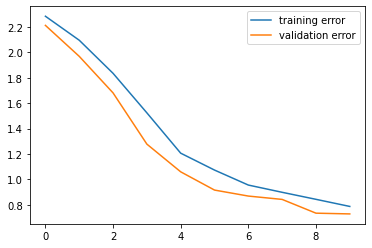

In [188]:
plt.plot(train_error_history, label='training error')
plt.plot(valid_error_history, label='validation error')
plt.legend()